In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
import os
import cv2
from skimage import io
from tqdm import tqdm

In [34]:
train = pd.read_csv(r'C:\train_ship_segmentations_v2.csv')
print("Total records", train.shape) 
train.head()

Total records (231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [35]:
train.count()

ImageId          231723
EncodedPixels     81723
dtype: int64

In [36]:
# data contains images without ships, check to see the amount of data without ships 

# an important factor, helps the model identify background and desired object; the ratio of images with no ships to images with ships can be tweaked based on model performance.
train['num_of_ships'] = train['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0) 

unique_img_ids = train.groupby('ImageId').agg({'num_of_ships': 'sum'}).reset_index()
unique_img_ids['is_ship'] = unique_img_ids['num_of_ships'].map(lambda x: 1.0 if x>0 else 0.0)

print("Number of images without ships >", unique_img_ids['is_ship'].value_counts()[0])
print("Number of images with ships>", unique_img_ids['is_ship'].value_counts()[1])

Number of images without ships > 150000
Number of images with ships> 42556


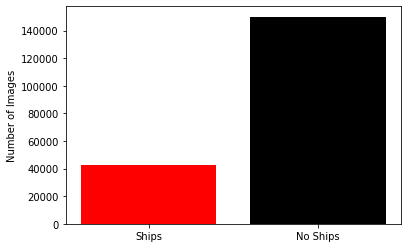

In [37]:
ships =train[~train.EncodedPixels.isna()].ImageId.unique()
noships =train[train.EncodedPixels.isna()].ImageId.unique()
plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)], color=["red","black"]);
plt.ylabel('Number of Images');

In [38]:
def ship_exist(encoded_pixels):
    hs = [0 if pd.isna(n) else 1 for n in tqdm(encoded_pixels)]
    return hs
train['ShipExist'] = ship_exist(train['EncodedPixels'].values)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231723/231723 [00:00<00:00, 617973.18it/s]


In [39]:
len(train.ImageId.unique())

192556

In [40]:
len(train.ImageId)

231723

In [41]:
len(train.EncodedPixels.unique())

81723

In [42]:
len(train.EncodedPixels)

231723

In [43]:
train.ImageId[train.ImageId.duplicated(keep=False)]

3         000194a2d.jpg
4         000194a2d.jpg
5         000194a2d.jpg
6         000194a2d.jpg
7         000194a2d.jpg
              ...      
231669    ffef7c3f3.jpg
231670    ffef7c3f3.jpg
231671    ffef7c3f3.jpg
231712    fffd924fb.jpg
231713    fffd924fb.jpg
Name: ImageId, Length: 54619, dtype: object

In [44]:
train.ImageId[train.ImageId.duplicated(keep=False)].unique()

array(['000194a2d.jpg', '00021ddc3.jpg', '0002756f7.jpg', ...,
       'ffea9a5ba.jpg', 'ffef7c3f3.jpg', 'fffd924fb.jpg'], dtype=object)

In [45]:
print(f"Count of images with number of ships \n{unique_img_ids['num_of_ships'].value_counts()}")

Count of images with number of ships 
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: num_of_ships, dtype: int64


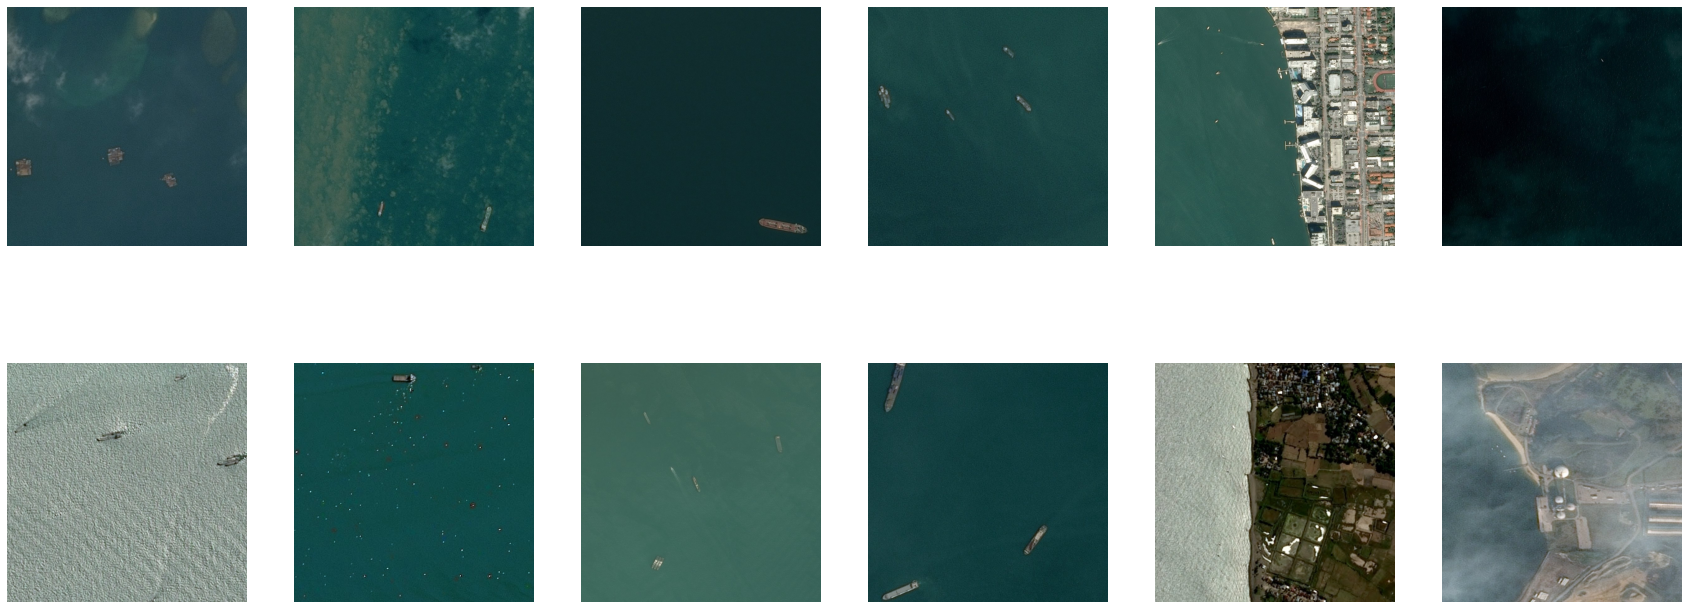

In [46]:
figure, axes = plt.subplots(nrows=2, ncols=6, figsize=(30, 12))
sample = train[~train.EncodedPixels.isna()].sample(12)

for item in zip(axes.ravel(), sample.ImageId):
    ax, num = item
    img = mpimg.imread(r'C:\Users\katia\OneDrive\Робочий стіл/train_v2/{}'.format(num))
    ax.imshow(img)
    ax.axis('off')

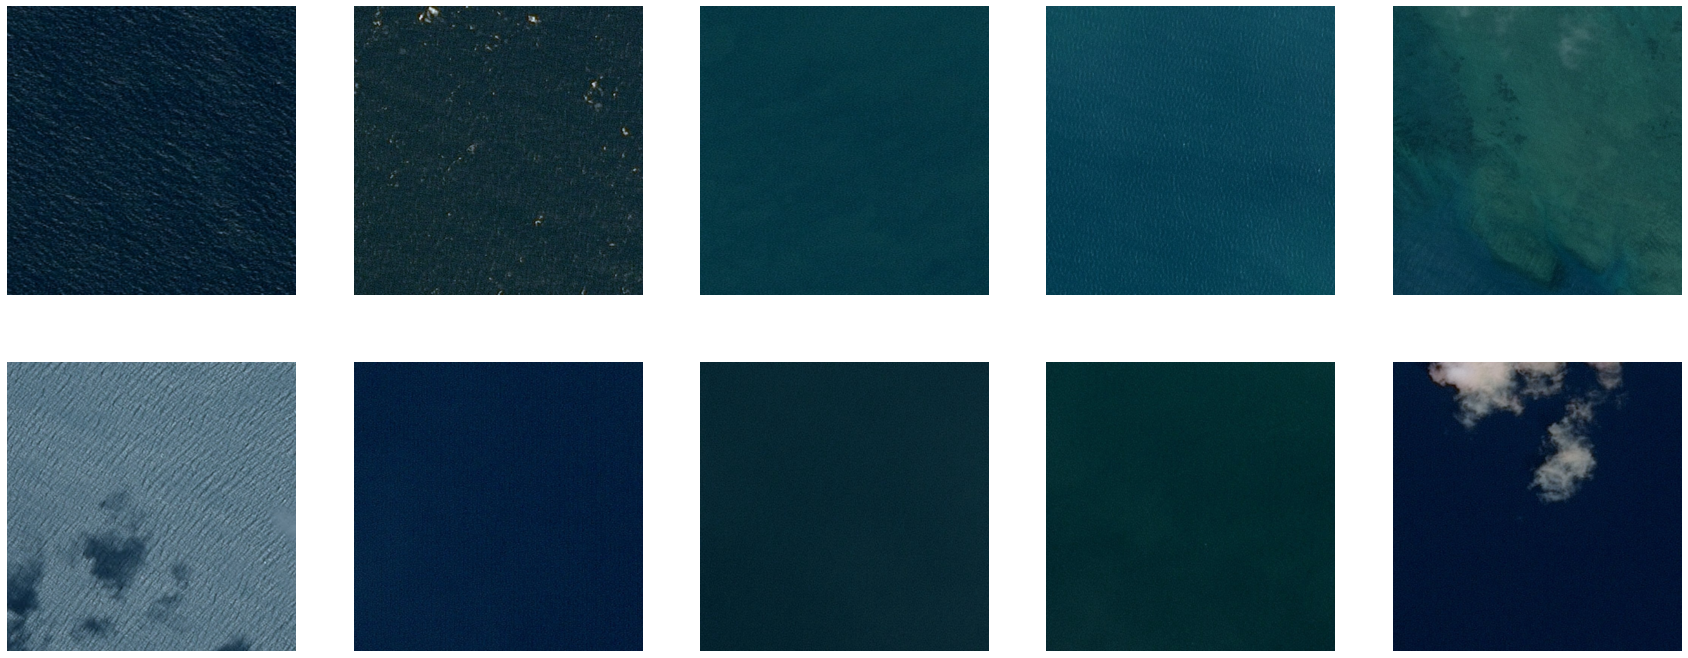

In [47]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 12))
sample = train[train.EncodedPixels.isna()].sample(12)

for item in zip(axes.ravel(), sample.ImageId):
    ax, num = item
    img = mpimg.imread(r'C:\Users\katia\OneDrive\Робочий стіл/train_v2/{}'.format(num))
    ax.imshow(img)
    ax.axis('off')

In [48]:
ships = train.dropna().groupby('ImageId').count()
ships.describe()


,EncodedPixels,num_of_ships,ShipExist
count,42556.000000,42556.000000,42556.000000
mean,1.920364,1.920364,1.920364
std,1.906073,1.906073,1.906073
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,15.000000,15.000000,15.000000


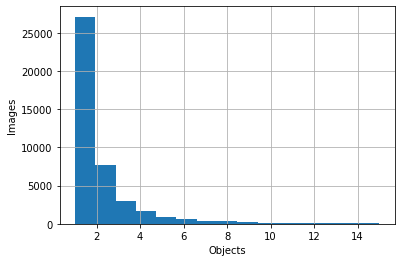

In [49]:
ships.EncodedPixels.hist(bins=15)
plt.xlabel('Objects')
plt.ylabel('Images')
plt.show()

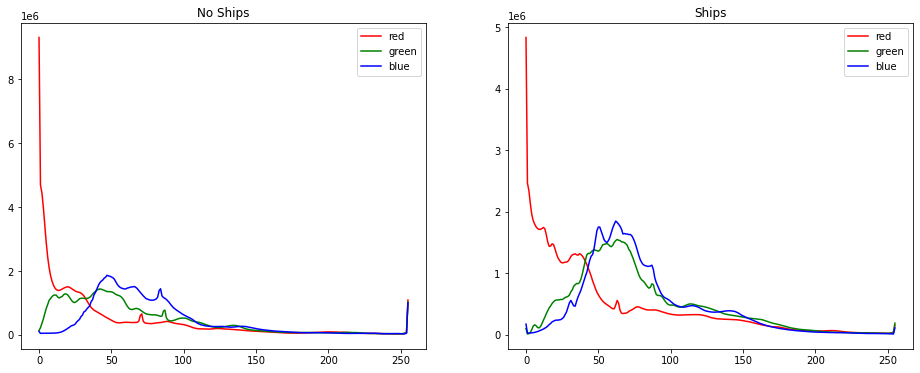

In [50]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    ids = train[msk].ImageId.sample(200)
    imgs = np.array([mpimg.imread(r'C:\Users\katia\OneDrive\Робочий стіл/train_v2/{}'.format(i)) for i in ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    axes[i].plot(np.bincount(red.ravel()), color='red', label='red')
    axes[i].plot(np.bincount(green.ravel()), color='green', label='green')
    axes[i].plot(np.bincount(blue.ravel()), color='blue', label='blue')
    
    axes[i].legend()
    axes[i].title.set_text(label)

In [51]:
def rle_decode(mask_rle, IMG_SIZE = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_SIZE[0]*IMG_SIZE[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(IMG_SIZE).T

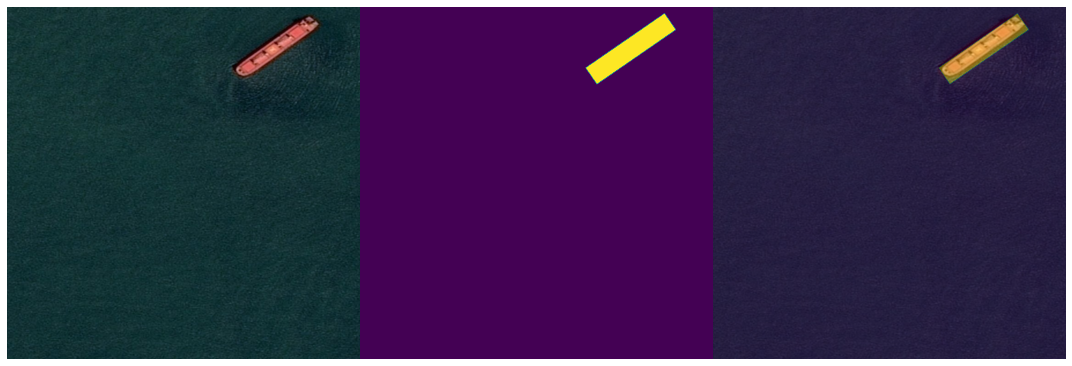

In [52]:
ImageId = '00a52cd2a.jpg'

img = io.imread(r'C:\Users\katia\OneDrive\Робочий стіл/train_v2/00a52cd2a.jpg')
img_masks = train.loc[train['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask, (768, 768))
    

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()